# Building RNN network from Scratch in Python

- Input: A sequence of numbers
- Output: Single scalar => Next value in the sequence
- Approach Credits: https://pythonalgos.com/build-a-recurrent-neural-network-from-scratch-in-python-3/


In [196]:
import math
from matplotlib import pyplot as plt
import numpy as np
import random

def get_sin_wave(noise = 0.05, points = 500):
    
    sin_wave = []
    c = 0.01
    for i in range(points):
        n = random.random()*noise
        sin_wave.append(c*i+10*math.sin(i*0.2+n)+3*math.sin(i*5))
    
    sin_wave = np.array(sin_wave)
    
    return sin_wave

In [197]:
seq_len = 10

def get_Data(sin_wave):
    X = []
    Y = []
    num_records = len(sin_wave) - seq_len

    for i in range(num_records):
        X.append(sin_wave[i:i+seq_len])
        Y.append(sin_wave[i+seq_len])

    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=1)
    
    return X,Y


# Data preparation

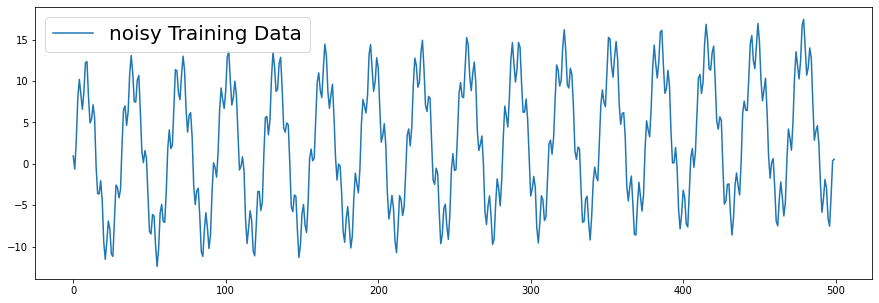

(490, 10, 1) (490, 1)


In [198]:
# Training Data

sin_wave = get_sin_wave(noise=0.1)
plt.figure(figsize=(15, 5))
plt.plot(sin_wave, label='noisy Training Data')
plt.legend(fontsize=20)
plt.show()

X,Y = get_Data(sin_wave)
print(X.shape, Y.shape)

# Now creating an RNN model
- Model takes in the input sequence, process it through a hidden layer of 100 units, and produce a single output

In [199]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [200]:
from tensorflow.python.keras import activations
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend
from tensorflow.python.util import nest
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops


class SimpleRNNCell(Layer):

  def __init__(self,units,activation='relu', use_bias=True, **kwargs):
    super(SimpleRNNCell, self).__init__(**kwargs)
    self.units = units
    self.activation = activations.get(activation)
    self.use_bias = use_bias
    self.state_size = self.units
    self.output_size = self.units

  def build(self, input_shape):
    self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        name='kernel')
    
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units),
        name='recurrent_kernel')
    if self.use_bias:
        self.bias = self.add_weight(shape=(self.units,), name='bias')
    else:
        self.bias = None
    
    self.built = True

  def call(self, inputs, states, training=None):
    prev_output = states[0] if nest.is_nested(states) else states
    
    
    h = backend.dot(inputs, self.kernel)
    
    if self.bias is not None:
        h = backend.bias_add(h, self.bias)

    output = h + backend.dot(prev_output, self.recurrent_kernel)
    if self.activation is not None:
        output = self.activation(output)

    new_state = [output] if nest.is_nested(states) else output
    return output, new_state

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    return _generate_zero_filled_state_for_cell(self, inputs, batch_size, dtype)


def _generate_zero_filled_state_for_cell(cell, inputs, batch_size, dtype):
  if inputs is not None:
    batch_size = array_ops.shape(inputs)[0]
    dtype = inputs.dtype
  return _generate_zero_filled_state(batch_size, cell.state_size, dtype)


def _generate_zero_filled_state(batch_size_tensor, state_size, dtype):
  """Generate a zero filled tensor with shape [batch_size, state_size]."""
  if batch_size_tensor is None or dtype is None:
    raise ValueError(
        'batch_size and dtype cannot be None while constructing initial state: '
        'batch_size={}, dtype={}'.format(batch_size_tensor, dtype))

  def create_zeros(unnested_state_size):
    flat_dims = tensor_shape.TensorShape(unnested_state_size).as_list()
    init_state_size = [batch_size_tensor] + flat_dims
    return array_ops.zeros(init_state_size, dtype=dtype)

  if nest.is_nested(state_size):
    return nest.map_structure(create_zeros, state_size)
  else:
    return create_zeros(state_size)





# Define the model

In [241]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.RNN(SimpleRNNCell(3)))
model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_27 (RNN)                 (None, 3)                 15        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [242]:
X_train = X[:1000]#np.vstack((X[:100]))
Y_train = Y[:1000]#np.vstack((Y[:100]))
print(X_train.shape, Y_train.shape)

(490, 10, 1) (490, 1)


In [243]:
model.fit(X_train, Y_train, batch_size=64, epochs=200,verbose=0)

In [244]:
y_pred = model.predict(X)

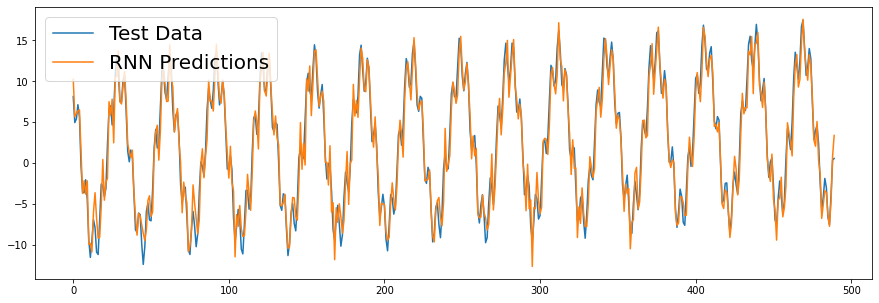

In [245]:
plt.figure(figsize=(15, 5))
plt.plot(Y[:,0], label='Test Data')
plt.plot(y_pred[:,0], label='RNN Predictions')
plt.legend(fontsize=20)
plt.show()

# Making Sine Operation as part of the Kernel

In [246]:
from tensorflow.python.keras import activations
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend
from tensorflow.python.util import nest
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops


class SimpleRNNCell2(Layer):

  def __init__(self,units,activation='relu', use_bias=True, **kwargs):
    super(SimpleRNNCell2, self).__init__(**kwargs)
    self.units = units
    self.activation = activations.get(activation)
    self.use_bias = use_bias
    self.state_size = self.units
    self.output_size = self.units

  def build(self, input_shape):
    self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        name='kernel')
    
    self.kernel2 = self.add_weight(
        shape=(input_shape[-1], self.units),
        name='kernel2')
    
    self.inp_bias = self.add_weight(
        shape=(input_shape[-1],),
        name='bias_2')
    
    self.recurrent_kernel = self.add_weight(
        shape=(self.units, self.units),
        name='recurrent_kernel')
    if self.use_bias:
        self.bias = self.add_weight(shape=(self.units,), name='bias')
    else:
        self.bias = None
    
    self.built = True

  def call(self, inputs, states, training=None):
    prev_output = states[0] if nest.is_nested(states) else states
    
    
    h = backend.dot(inputs, self.kernel)
    
    
    inputs2 = inputs#tf.math.sin(inputs) 
    h2 = backend.dot(inputs2, self.kernel2)
    h2 = h2+self.inp_bias*inputs
    
    if self.bias is not None:
        h = backend.bias_add(h, self.bias)

    output = h2 + h + backend.dot(prev_output, self.recurrent_kernel)
    if self.activation is not None:
        output = self.activation(output)

    new_state = [output] if nest.is_nested(states) else output
    return output, new_state

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    return _generate_zero_filled_state_for_cell(self, inputs, batch_size, dtype)


def _generate_zero_filled_state_for_cell(cell, inputs, batch_size, dtype):
  if inputs is not None:
    batch_size = array_ops.shape(inputs)[0]
    dtype = inputs.dtype
  return _generate_zero_filled_state(batch_size, cell.state_size, dtype)


def _generate_zero_filled_state(batch_size_tensor, state_size, dtype):
  """Generate a zero filled tensor with shape [batch_size, state_size]."""
  if batch_size_tensor is None or dtype is None:
    raise ValueError(
        'batch_size and dtype cannot be None while constructing initial state: '
        'batch_size={}, dtype={}'.format(batch_size_tensor, dtype))

  def create_zeros(unnested_state_size):
    flat_dims = tensor_shape.TensorShape(unnested_state_size).as_list()
    init_state_size = [batch_size_tensor] + flat_dims
    return array_ops.zeros(init_state_size, dtype=dtype)

  if nest.is_nested(state_size):
    return nest.map_structure(create_zeros, state_size)
  else:
    return create_zeros(state_size)




In [247]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.RNN(SimpleRNNCell2(3)))
model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_28 (RNN)                 (None, 3)                 19        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 4         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [248]:
# X_train = np.vstack((X[:50],X[150:200]))
# Y_train = np.vstack((Y[:50],Y[150:200]))
# print(X_train.shape, Y_train.shape)

In [249]:
model.fit(X_train, Y_train, batch_size=64, epochs=200,
            verbose=0)

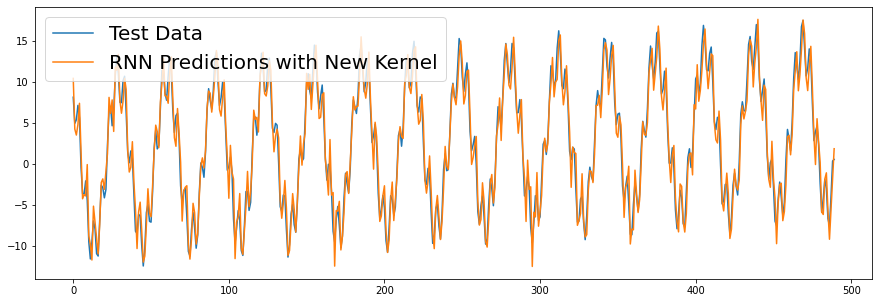

In [250]:
y_pred = model.predict(X)

plt.figure(figsize=(15, 5))
plt.plot(Y[:,0], label='Test Data')
plt.plot(y_pred[:,0], label='RNN Predictions with New Kernel')
plt.legend(fontsize=20)
plt.show()